In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time

## User input

In [2]:
sample_prefix = 'C:\\Data\Ashlee\\20190221_D1-3_exchange\\PIB_blank\\m190221_154338_42131_c000471062559900001500000112312180_s1_p0'

In [3]:
def plot_one_trace(data, traceID, time_axis, foi):
#     plt.figure(figsize=(15, 2))
    trc = data[traceID]
    shape = data.shape
    if len(shape) == 2:
        plt.plot(time_axis[foi], trc[foi])
    else:
        n_channels = data.shape[1]
        for j in range(n_channels):
            plt.plot(time_axis[foi], trc[j][foi], color=colors[j], linewidth=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(traceID))

## Load data

In [4]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

print("Time passed: " + str(time() - start))

Time passed: 0.003988981246948242


## View a trace

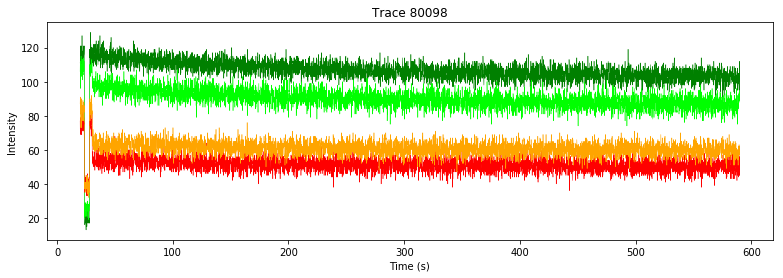

In [5]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
plot_one_trace(raw_traces, traceID, time_axis, range(200, n_frames))

## Preprocessing

In [6]:
foi = range(1000, 1100) # frames of interest
n_frames = len(foi)

In [7]:
traces = np.zeros((n_traces, 4, n_frames), dtype=np.uint8)
traces = raw_traces[:, :, foi]
avg_intens = np.mean(traces, axis=2)

## Plot intensity distributions

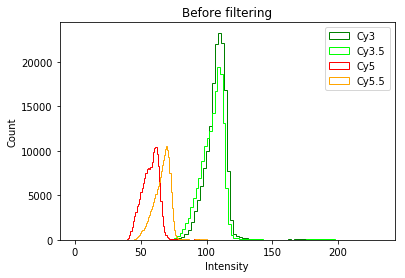

In [8]:
plt.figure()
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Before filtering")
plt.legend(lasers)

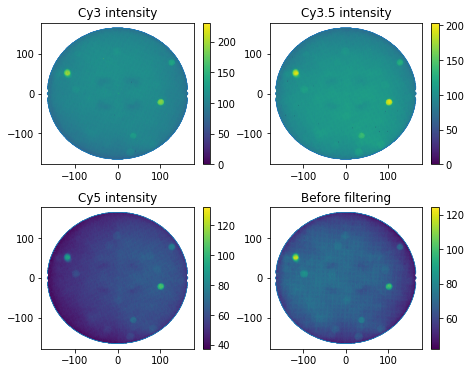

In [9]:
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.title("Before filtering")
plt.savefig(sample_prefix + '_grid.png')
plt.show()

In [10]:
np.savetxt(sample_prefix + "_background.csv", avg_intens, delimiter=",")